In [40]:
%%capture
import re # to handle regular expression
import demoji  # for emojis handle
import random # to generate random number
import inflect  # to handle number to words
import numpy as np # scitific calculation 
import pandas as pd # data manipulation 
from bs4 import BeautifulSoup # handle html tag
import matplotlib.pyplot as plt # plot any display

import torch # deep learning handle
import torchtext # nlp handle
import torch.nn as nn # NN handle
import torch.optim as optim # optimizer handle
import torch.nn.functional as F # all type to DL funciton
from torch.nn.functional import one_hot # encoder-decoder
from torchtext.data.utils import get_tokenizer # tokenize 
print('Successfully import all the libraries')

In [41]:
# Reading the text 
file_path = 'human_chat.txt'
with open(file_path,"r") as f:
    lines = f.readlines()

In [42]:
lines

['Human 1: Hi!\n',
 'Human 2: What is your favorite holiday?\n',
 'Human 1: one where I get to meet lots of different people.\n',
 'Human 2: What was the most number of people you have ever met during a holiday?\n',
 'Human 1: Hard to keep a count. Maybe 25.\n',
 'Human 2: Which holiday was that?\n',
 'Human 1: I think it was Australia\n',
 'Human 2: Do you still talk to the people you met?\n',
 "Human 1: Not really. The interactions are usually short-lived but it's fascinating to learn where people are coming from and what matters to them\n",
 'Human 2: Yea, me too. I feel like God often puts strangers in front of you, and gives you an opportunity to connect with them in that moment in deeply meaningful ways. Do you ever feel like you know things about strangers without them telling you?\n',
 'Human 1: what do you mean?\n',
 'Human 2: I think it\'s like a 6th sense, often seen as "cold readings" to people, but can be remarkably accurate. I once sat next to a man in a coffee and I felt

In [43]:
def preprocessing_text_method(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    p = inflect.engine() #101
    # demoji.download_codes()
    # Remove emojis
    text = demoji.replace(text, "")

    # Remove mentions of "Human 1" and "Human 2"
    text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)

    # Replace numbers with words
    text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)

    # Remove special characters, keeping only alphabetic and spaces
    text = re.sub('[^a-zA-Z\s]', ' ', text)

    # Replace specific unicode spaces with standard spaces and trim
    text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

    return text

In [44]:
# Execute the function code
import warnings
from bs4 import MarkupResemblesLocatorWarning
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning) # use to handle the error handle of markupresembl
processed_text = [preprocessing_text_method(line) for line in lines]
processed_text[:5]

['Hi',
 'What is your favorite holiday',
 'one where I get to meet lots of different people',
 'What was the most number of people you have ever met during a holiday',
 'Hard to keep a count  Maybe twenty five']

In [45]:
# Tokenize words
tokenizer = get_tokenizer('basic_english')
tokenized_text = [tokenizer(line) for line in processed_text]

In [46]:
tokenized_text[1]

['what', 'is', 'your', 'favorite', 'holiday']

In [47]:
feature_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_text,
    min_freq=1,
    specials = [
        '<pad>',
        '<oov>'
    ],
    special_first = True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_text,
    min_freq=1
)

In [48]:
features_vocab_total_words = len(feature_vocab)
target_vocab_total_words = len(target_vocab)

print('Features Vocab Length:', features_vocab_total_words)
print("Target Vocab Length:", target_vocab_total_words)

Features Vocab Length: 2749
Target Vocab Length: 2747


In [49]:
# N-gram from the tokenized text
def make_ngrams(tokenized_text):
    list_ngrams = []
    for i in range(1, len(tokenized_text)):
        ngram_sequence = tokenized_text[:i+1]
        list_ngrams.append(ngram_sequence)
    return list_ngrams

In [50]:
# Execute the function and make ngram
ngrams_list = []
for tokenize_con in tokenized_text:
    ngrams_list.extend(make_ngrams(tokenized_text=tokenize_con))

In [51]:
ngrams_list[:10]

[['what', 'is'],
 ['what', 'is', 'your'],
 ['what', 'is', 'your', 'favorite'],
 ['what', 'is', 'your', 'favorite', 'holiday'],
 ['one', 'where'],
 ['one', 'where', 'i'],
 ['one', 'where', 'i', 'get'],
 ['one', 'where', 'i', 'get', 'to'],
 ['one', 'where', 'i', 'get', 'to', 'meet'],
 ['one', 'where', 'i', 'get', 'to', 'meet', 'lots']]

In [52]:
import random
# add random oov takens to let the model handle the out of vocabulary takens
def add_random_oov_token(ngram):
    for idx, word in enumerate(ngram[:-1]):
        if random.uniform(0,1) < 0.1:
            ngram[idx] = '<oov>'
    return ngram

In [53]:
ngrams_list_oov = []

for ngram in ngrams_list:
    ngrams_list_oov.append(add_random_oov_token(ngram))
print(any('<oov>' in ngram for ngram in ngrams_list_oov))


True


In [54]:
ngrams_list_oov[:10]

[['<oov>', 'is'],
 ['what', 'is', 'your'],
 ['what', 'is', 'your', 'favorite'],
 ['what', 'is', 'your', 'favorite', 'holiday'],
 ['one', 'where'],
 ['one', 'where', 'i'],
 ['one', 'where', 'i', 'get'],
 ['one', 'where', 'i', 'get', 'to'],
 ['one', 'where', 'i', 'get', '<oov>', 'meet'],
 ['one', 'where', 'i', 'get', 'to', 'meet', 'lots']]

In [55]:
def text_to_numerical_sequence(tokenized_texts):
    tokens_list = []
    if tokenized_texts[-1] in target_vocab.get_itos():
        for token in tokenized_texts[:-1]:
            num_token = feature_vocab[token] if token in feature_vocab.get_itos() else feature_vocab['<oov>']
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_texts[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None

In [56]:
input_sequence = [text_to_numerical_sequence(sequence) for sequence in ngrams_list_oov if text_to_numerical_sequence(sequence)]

In [57]:
print(f'Total Input Sequence: {len(input_sequence)}')
print(input_sequence[7:9])

Total Input Sequence: 18562
[[56, 90, 2, 73, 2], [56, 90, 2, 73, 1, 228]]


In [58]:
X = [sequence[:-1] for sequence in input_sequence]
y = [sequence[-1] for sequence in input_sequence]
len(X[3]), y[3]

(4, 312)

In [59]:
print(X[3], y[3])

[12, 13, 29, 120] 312


In [60]:
longest_sequence_feature = max(len(sequence) for sequence in X)
longest_sequence_feature

153

In [61]:
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature - len(sequence),0), value=0) for sequence in X]

In [62]:
padded_X[1], X[2], len(padded_X[1])

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0, 12, 13]),
 [12, 13, 29],
 153)

In [63]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)
type(y), type(padded_X)

(torch.Tensor, torch.Tensor)

In [64]:
y_one_hot_encode = one_hot(y, num_classes=target_vocab_total_words)
len(y_one_hot_encode[2])

2747

In [65]:
from torch.utils.data import TensorDataset
data = TensorDataset(padded_X, y_one_hot_encode)

In [66]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32

In [67]:
# split the dataset 
from torch.utils.data import random_split
train_data, test_data = random_split(data, [train_size, test_size])

In [68]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [69]:
class Bi_LSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(Bi_LSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)

        output = self.fc(torch.cat((lstm_out[:, -1,:hidden_dim], lstm_out[:,0,hidden_dim:]), dim=1))
        return output

In [70]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
epochs = 50

In [71]:
bi_model = Bi_LSTM(features_vocab_total_words,target_vocab_total_words,embedding_dim=embedding_dim, hidden_dim=hidden_dim)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bi_model.parameters(), lr=0.0009)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [74]:
bi_model.to(device)

Bi_LSTM(
  (embedding): Embedding(2749, 128)
  (lstm): LSTM(128, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=2747, bias=True)
)

In [75]:
def calculate_topk_accuracy(model, data_loader, k=3):
    bi_model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = bi_model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy


In [76]:
all_accuracies = []
all_losses = []

for epoch in range(epochs):
    bi_model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = bi_model(batch_X)
        
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracy(bi_model, train_loader)
        print(f'Epoch {epoch}/{epochs}| Loss: {loss.item():.4f}| Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())
            

Epoch 0/50| Loss: 2.4737| Train K-Accuracy: 19.66%
Epoch 5/50| Loss: 2.6742| Train K-Accuracy: 47.95%
Epoch 10/50| Loss: 4.8590| Train K-Accuracy: 80.49%
Epoch 15/50| Loss: 1.6712| Train K-Accuracy: 91.18%
Epoch 20/50| Loss: 0.0010| Train K-Accuracy: 94.40%
Epoch 25/50| Loss: 0.5989| Train K-Accuracy: 95.16%
Epoch 30/50| Loss: 0.0351| Train K-Accuracy: 95.55%
Epoch 35/50| Loss: 0.2880| Train K-Accuracy: 95.80%
Epoch 40/50| Loss: 0.0382| Train K-Accuracy: 95.87%
Epoch 45/50| Loss: 0.0153| Train K-Accuracy: 95.89%


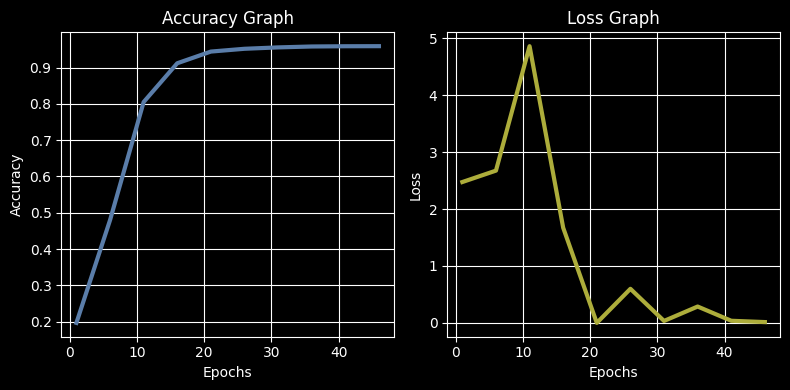

In [79]:
epoch_list= [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)

axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()



In [80]:
accuracy = calculate_topk_accuracy(bi_model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')

Test K-Accuracy: 20.50%


We won't save this model, becase this is wrong model prediction.